In [ ]:
!pip install pyspark
!pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [90]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month
import pandas as pd
import seaborn as sns

# Initialize the spark session
spark = SparkSession.builder.appName("HealthcareAnalysis").getOrCreate()

In [60]:
admissions_df = spark.read.csv(
    "./dataset/HDHI_Admission_data.csv", header=True, inferSchema=True)
mortality_df = spark.read.csv(
    "./dataset/HDHI_Mortality_Data.csv", header=True, inferSchema=True)
pollution_df = spark.read.csv(
    "./dataset/HDHI_Pollution_Data.csv", header=True, inferSchema=True)

## SQL Version

In [61]:
# Register DataFrames as temporary views
admissions_df.createOrReplaceTempView("admissions")
mortality_df.createOrReplaceTempView("mortality")
pollution_df.createOrReplaceTempView("pollution")

In [62]:
# Query 1: Analyze admission trends by age group and gender
age_gender_analysis = spark.sql("""
    SELECT 
        CASE 
            WHEN AGE < 18 THEN 'Child'
            WHEN AGE BETWEEN 18 AND 35 THEN 'Young Adult'
            WHEN AGE BETWEEN 36 AND 55 THEN 'Adult'
            ELSE 'Senior'
        END AS age_group,
        GENDER,
        COUNT(*) as admission_count
    FROM admissions
    GROUP BY 1, 2
    ORDER BY 1, 2
""")

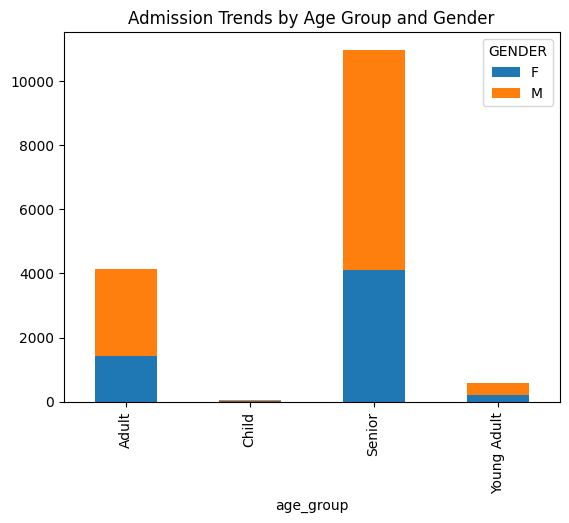

In [63]:
# Visualize admission trends
age_gender_data = age_gender_analysis.toPandas()
age_gender_data.pivot(index='age_group', columns='GENDER',
                      values='admission_count').plot(kind='bar', stacked=True)
plt.title('Admission Trends by Age Group and Gender')
plt.show()

In [64]:

# Query 2: Analyze correlation between pollution levels and mortality
pollution_mortality = spark.sql("""
    SELECT 
        p.DATE,
        p.AQI,
        p.PM2_5_AVG,
        COUNT(m.MRD) as mortality_count
    FROM pollution p
    LEFT JOIN mortality m ON p.DATE = m.`DATE OF BROUGHT DEAD`
    GROUP BY 1, 2, 3
    ORDER BY 1
""")

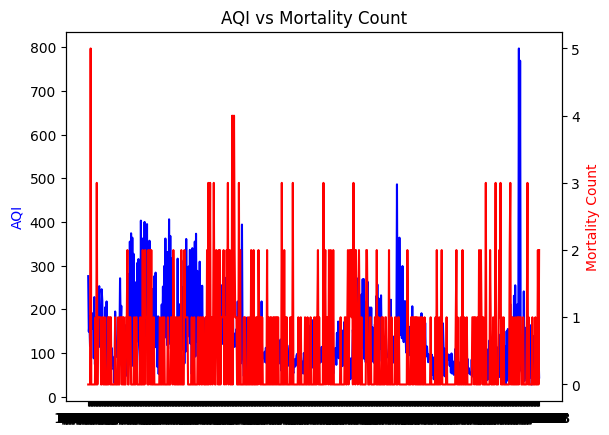

In [66]:
# Visualize pollution and mortality correlation
pollution_mortality_data = pollution_mortality.toPandas()
fig, ax1 = plt.subplots()
ax1.plot(pollution_mortality_data['DATE'],
         pollution_mortality_data['AQI'], color='blue')
ax1.set_ylabel('AQI', color='blue')
ax2 = ax1.twinx()
ax2.plot(pollution_mortality_data['DATE'],
         pollution_mortality_data['mortality_count'], color='red')
ax2.set_ylabel('Mortality Count', color='red')
plt.title('AQI vs Mortality Count')
plt.show()

In [67]:

# Query 3: Analyze common comorbidities
comorbidities = spark.sql("""
    SELECT 
        SUM(CASE WHEN DM = 1 THEN 1 ELSE 0 END) as diabetes_count,
        SUM(CASE WHEN HTN = 1 THEN 1 ELSE 0 END) as hypertension_count,
        SUM(CASE WHEN CAD = 1 THEN 1 ELSE 0 END) as cad_count,
        SUM(CASE WHEN CKD = 1 THEN 1 ELSE 0 END) as ckd_count,
        COUNT(*) as total_admissions
    FROM admissions
""")

In [68]:

# Visualize the commordibities
comorbidities_data = comorbidities.toPandas()

In [69]:
comorbidity_results = comorbidities.collect()[0]
total_admissions = comorbidity_results['total_admissions']
diabetes_prevalence = comorbidity_results['diabetes_count'] / \
    total_admissions * 100
hypertension_prevalence = comorbidity_results['hypertension_count'] / \
    total_admissions * 100
cad_prevalence = comorbidity_results['cad_count'] / total_admissions * 100
ckd_prevalence = comorbidity_results['ckd_count'] / total_admissions * 100

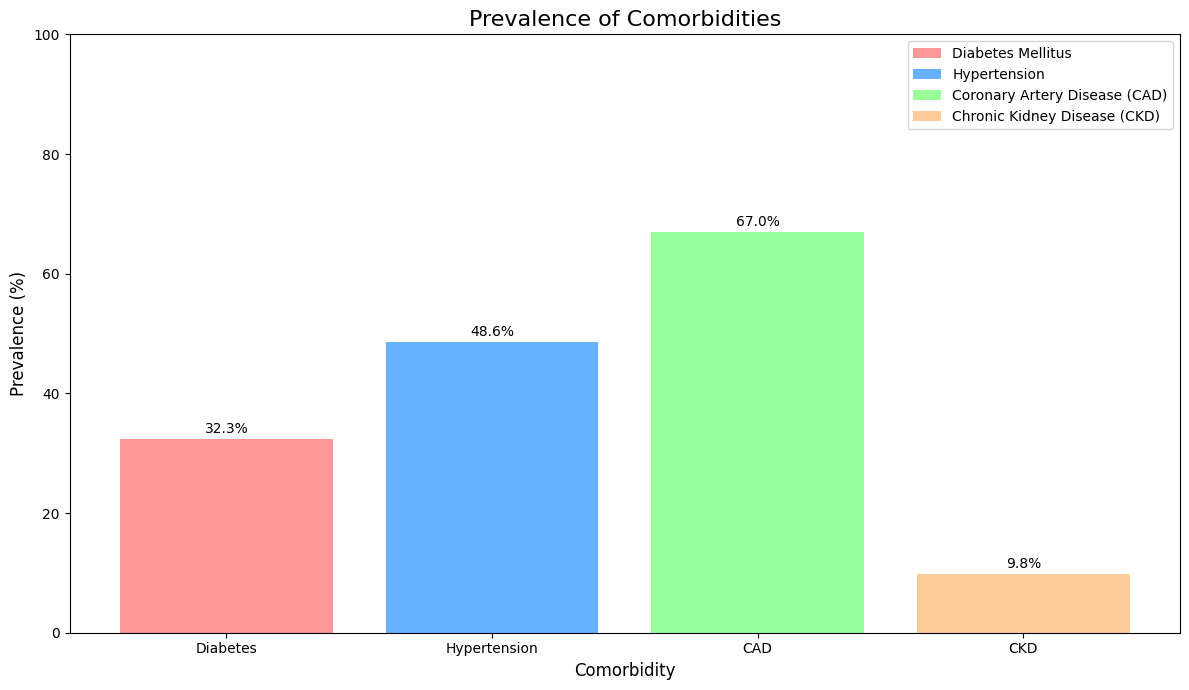

In [70]:
comorbidities = ['Diabetes', 'Hypertension', 'CAD', 'CKD']
prevalences = [diabetes_prevalence,
               hypertension_prevalence, cad_prevalence, ckd_prevalence]
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

plt.figure(figsize=(12, 7))
bars = plt.bar(comorbidities, prevalences, color=colors)
plt.title('Prevalence of Comorbidities', fontsize=16)
plt.xlabel('Comorbidity', fontsize=12)
plt.ylabel('Prevalence (%)', fontsize=12)
plt.ylim(0, 100)

for i, v in enumerate(prevalences):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.legend(bars, ['Diabetes Mellitus', 'Hypertension',
                  'Coronary Artery Disease (CAD)',
                  'Chronic Kidney Disease (CKD)'],
           loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [71]:


# Add year and month columns
admissions_df = admissions_df.withColumn("year", year("`D.O.A`"))
admissions_df = admissions_df.withColumn("month", month("`D.O.A`"))

In [73]:
admission_counts = admissions_df.groupBy(
    "`D.O.A`").count().withColumnRenamed("count", "Admissions")
admission_counts = admission_counts.orderBy("`D.O.A`")

In [74]:

admission_counts_pd = admission_counts.toPandas()
admission_counts_pd['D.O.A'] = pd.to_datetime(
    admission_counts_pd['D.O.A'], format='%m/%d/%Y', errors='coerce'
)
admission_counts_pd = admission_counts_pd.sort_values(by='D.O.A')

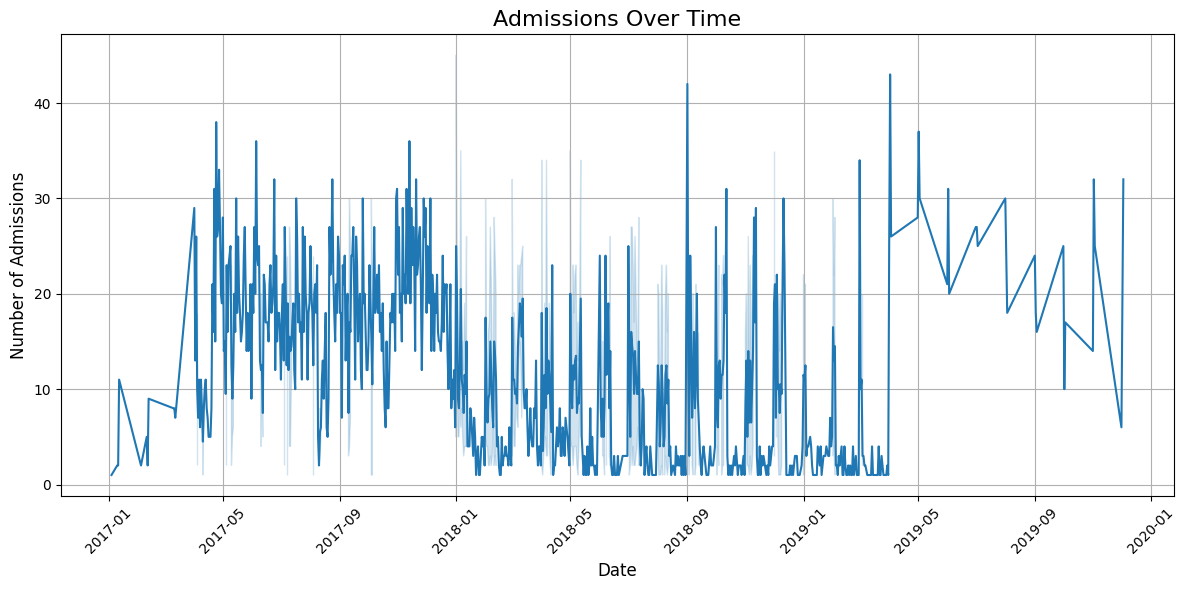

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(x='D.O.A', y='Admissions', data=admission_counts_pd)
plt.title('Admissions Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

In [92]:
# Prepare data for mortality prediction
ml_data = admissions_df.select(
    col("AGE"), col("GENDER"), col("DM"), col("HTN"), col("CAD"), col("CKD"),
    (col("OUTCOME") == "EXPIRY").cast("int").alias("mortality")
)
ml_data.printSchema()

root
 |-- AGE: integer (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- DM: integer (nullable = true)
 |-- HTN: integer (nullable = true)
 |-- CAD: integer (nullable = true)
 |-- CKD: integer (nullable = true)
 |-- mortality: integer (nullable = true)



In [93]:


# Convert GENDER to numeric
gender_indexer = StringIndexer(inputCol="GENDER", outputCol="GENDER_INDEX")
ml_data = gender_indexer.fit(ml_data).transform(ml_data)

In [94]:


# Create feature vector
assembler = VectorAssembler(
    inputCols=["AGE", "GENDER_INDEX", "DM", "HTN", "CAD", "CKD"],
    outputCol="features"
)
ml_data = assembler.transform(ml_data)

In [95]:
from pyspark.sql.functions import col

ml_data = ml_data.withColumn("DM", col("DM").cast("double"))
ml_data = ml_data.withColumn("HTN", col("HTN").cast("double"))
ml_data = ml_data.withColumn("CAD", col("CAD").cast("double"))
ml_data = ml_data.withColumn("CKD", col("CKD").cast("double"))

In [96]:
# Split data
train_data, test_data = ml_data.randomSplit([0.7, 0.3], seed=42)

# Train Random Forest model
rf = RandomForestClassifier(
    labelCol="mortality", featuresCol="features", numTrees=10)
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate model
evaluator = BinaryClassificationEvaluator(labelCol="mortality")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7022145412190575


## High Pollution 

In [82]:
pollution_mortality_data = spark.sql("""SELECT
    p.DATE,
    AVG(p.AQI) AS avg_aqi,
    COUNT(m.MRD) AS mortality_count
FROM
    pollution p
LEFT JOIN
    mortality m ON p.DATE = m.`DATE OF BROUGHT DEAD`
GROUP BY
    p.DATE
ORDER BY
    p.DATE;""").toPandas()

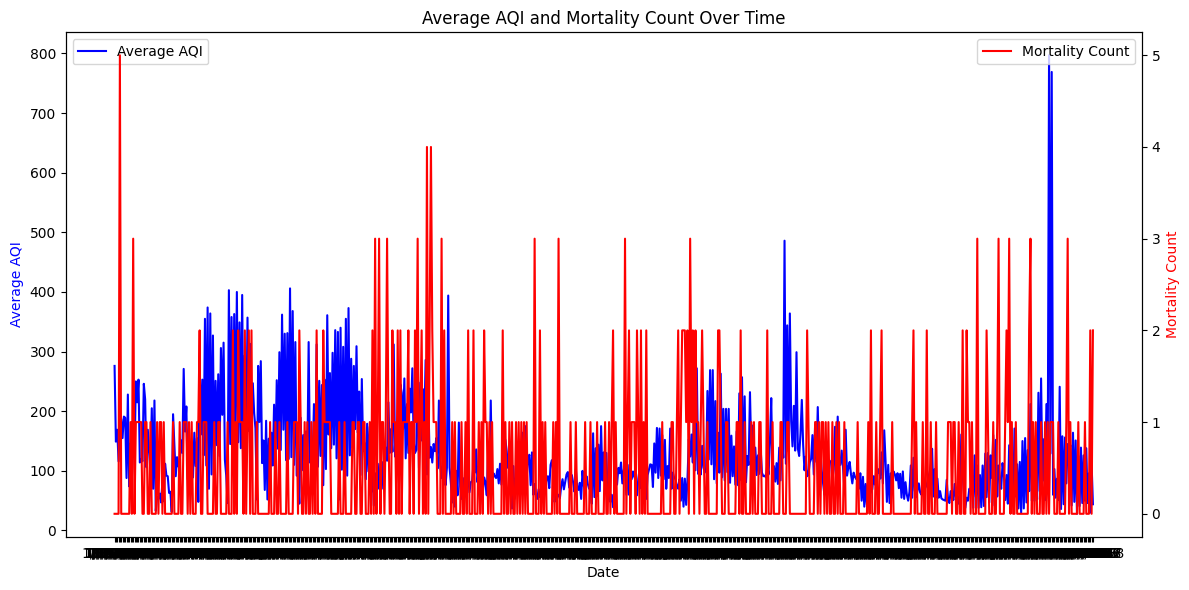

In [83]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(pollution_mortality_data['DATE'],
         pollution_mortality_data['avg_aqi'], color='blue', label='Average AQI')
ax2.plot(pollution_mortality_data['DATE'],
         pollution_mortality_data['mortality_count'], color='red', label='Mortality Count')

ax1.set_xlabel('Date')
ax1.set_ylabel('Average AQI', color='blue')
ax2.set_ylabel('Mortality Count', color='red')

plt.title('Average AQI and Mortality Count Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [84]:
disease_prevalence = spark.sql("""
SELECT
    a.GENDER,
    a.OUTCOME,
    SUM(CASE WHEN a.DM = 1 THEN 1 ELSE 0 END) AS diabetes_count,
    SUM(CASE WHEN a.HTN = 1 THEN 1 ELSE 0 END) AS hypertension_count,
    SUM(CASE WHEN a.CAD = 1 THEN 1 ELSE 0 END) AS cad_count,
    SUM(CASE WHEN a.CKD = 1 THEN 1 ELSE 0 END) AS ckd_count,
    COUNT(*) AS total_admissions
FROM
    admissions a
GROUP BY
    a.GENDER, a.OUTCOME
ORDER BY
    a.GENDER, a.OUTCOME;
""").toPandas()

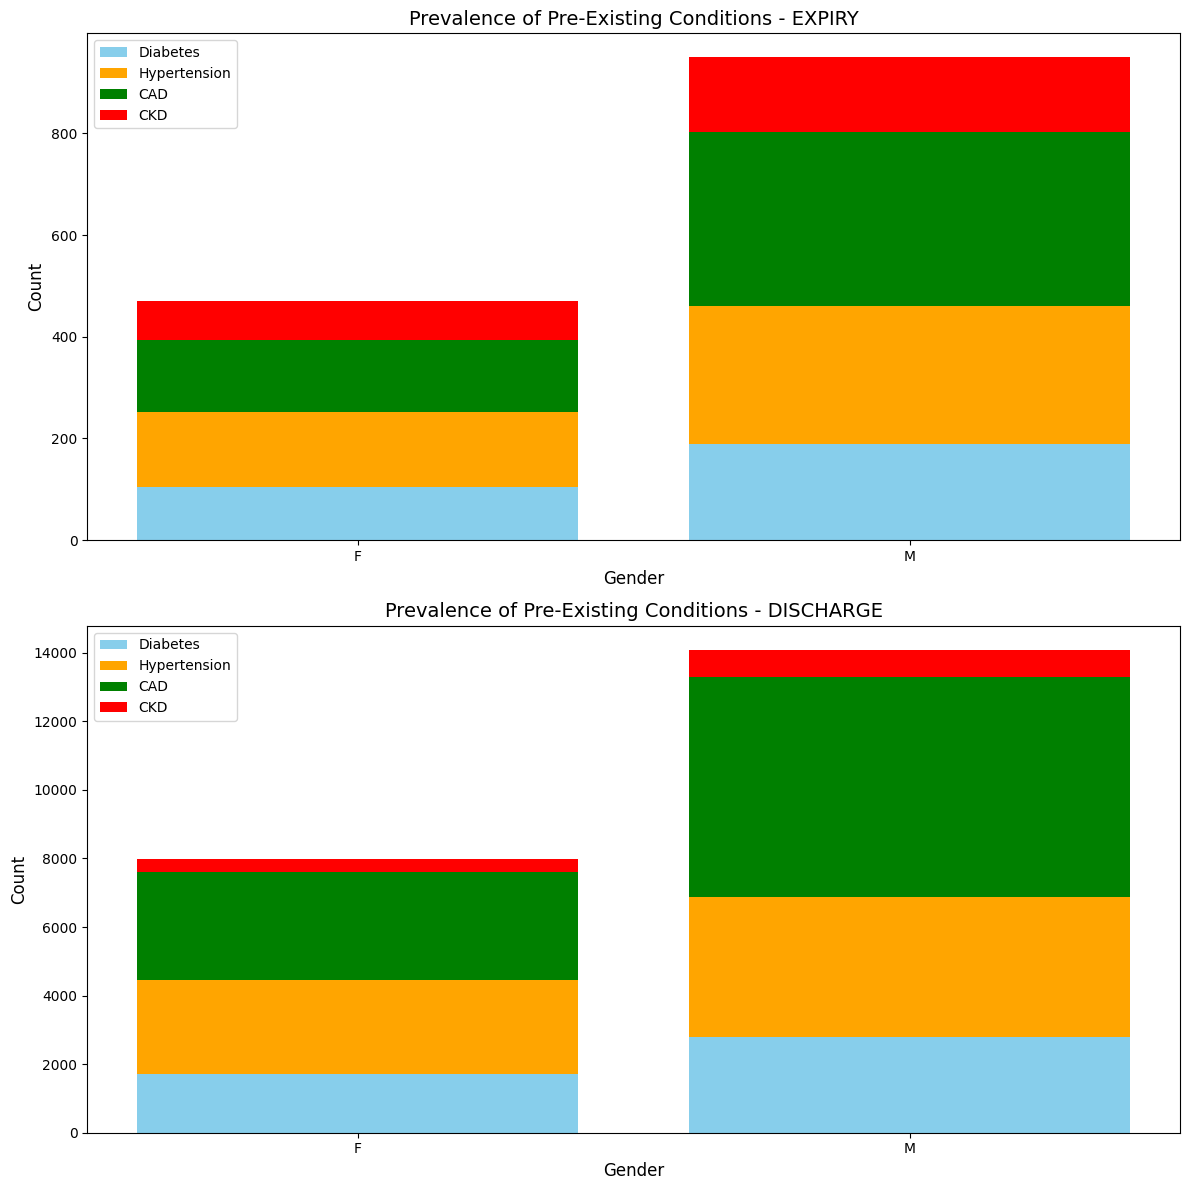

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

df_expiry = disease_prevalence[disease_prevalence['OUTCOME'] == 'EXPIRY']
if not df_expiry.empty:
    axes[0].bar(df_expiry['GENDER'], df_expiry['diabetes_count'],
                label='Diabetes', color='skyblue')
    axes[0].bar(df_expiry['GENDER'], df_expiry['hypertension_count'],
                label='Hypertension', bottom=df_expiry['diabetes_count'], color='orange')
    axes[0].bar(df_expiry['GENDER'], df_expiry['cad_count'], label='CAD',
                bottom=df_expiry['diabetes_count'] + df_expiry['hypertension_count'], color='green')
    axes[0].bar(df_expiry['GENDER'], df_expiry['ckd_count'], label='CKD', bottom=df_expiry['diabetes_count'] +
                df_expiry['hypertension_count'] + df_expiry['cad_count'], color='red')
    axes[0].set_title(
        'Prevalence of Pre-Existing Conditions - EXPIRY', fontsize=14)
    axes[0].set_xlabel('Gender', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].legend()

df_discharge = disease_prevalence[disease_prevalence['OUTCOME'] == 'DISCHARGE']
if not df_discharge.empty:
    axes[1].bar(df_discharge['GENDER'], df_discharge['diabetes_count'],
                label='Diabetes', color='skyblue')
    axes[1].bar(df_discharge['GENDER'], df_discharge['hypertension_count'],
                label='Hypertension', bottom=df_discharge['diabetes_count'], color='orange')
    axes[1].bar(df_discharge['GENDER'], df_discharge['cad_count'], label='CAD',
                bottom=df_discharge['diabetes_count'] + df_discharge['hypertension_count'], color='green')
    axes[1].bar(df_discharge['GENDER'], df_discharge['ckd_count'], label='CKD', bottom=df_discharge['diabetes_count'] +
                df_discharge['hypertension_count'] + df_discharge['cad_count'], color='red')
    axes[1].set_title(
        'Prevalence of Pre-Existing Conditions - DISCHARGE', fontsize=14)
    axes[1].set_xlabel('Gender', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].legend()

plt.tight_layout()
plt.show()

In [86]:
avg_duration_by_admission_type = spark.sql("""
SELECT
    `TYPE OF ADMISSION-EMERGENCY/OPD`,
    AVG(`DURATION OF STAY`) AS avg_duration
FROM
    admissions
GROUP BY
    `TYPE OF ADMISSION-EMERGENCY/OPD`;
""").toPandas()

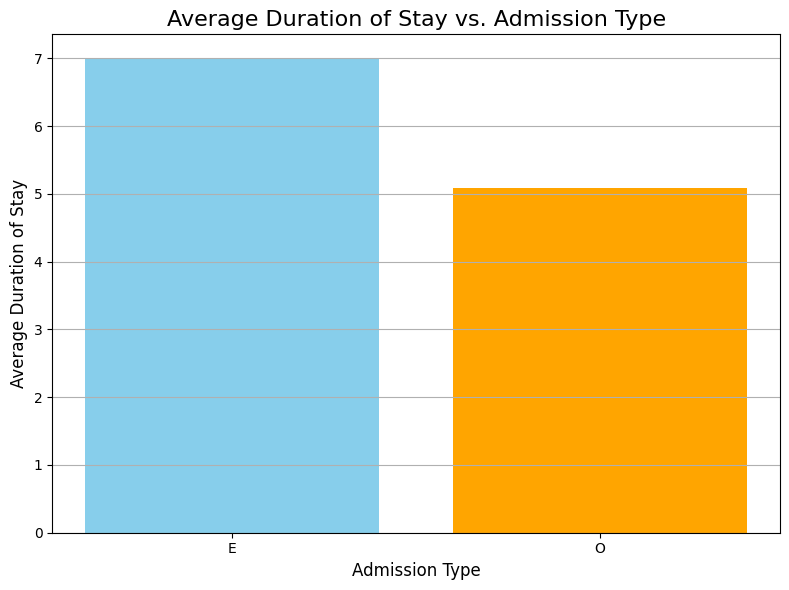

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(avg_duration_by_admission_type['TYPE OF ADMISSION-EMERGENCY/OPD'],
        avg_duration_by_admission_type['avg_duration'], color=['skyblue', 'orange'])
plt.title('Average Duration of Stay vs. Admission Type', fontsize=16)
plt.xlabel('Admission Type', fontsize=12)
plt.ylabel('Average Duration of Stay', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [88]:
area_mortality_avg_aqi = spark.sql("""SELECT
    m.`RURAL/URBAN`,
    AVG(p.AQI) AS avg_aqi
FROM
    mortality m
LEFT JOIN
    pollution p ON m.`DATE OF BROUGHT DEAD` = p.DATE
GROUP BY
    m.`RURAL/URBAN`;""").toPandas()

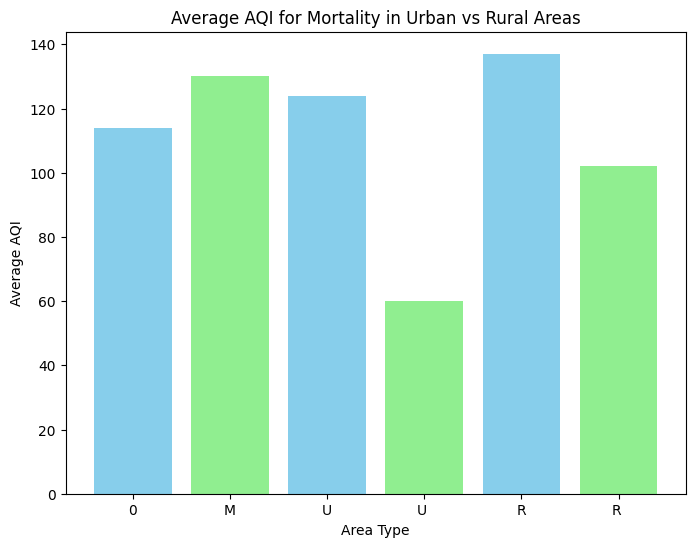

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(area_mortality_avg_aqi['RURAL/URBAN'],
        area_mortality_avg_aqi['avg_aqi'], color=['skyblue', 'lightgreen'])
plt.title('Average AQI for Mortality in Urban vs Rural Areas')
plt.xlabel('Area Type')
plt.ylabel('Average AQI')
plt.show()